In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
import random
from math import sqrt
import imageio as io

In [4]:
'''
A wrapper class for our dataset from ImageNet-200 (only 200,000 images), where we perform the transformations and then masking to image inputs 
'''
class D2VImageDataset(Dataset):
    
    def __init__(self, image_path: str):
        self.image_path = image_path
        self.PatchEmbed = PatchEmbedding()
        self.MaskGen = MaskGenerator()
        
    def __getitem__(self, index):
        '''
        This function is needed to build a dataloader
        - need to figure out the structure of the pathnames given by the query
        - also need to split pathnames into train/test split s.t. path looks like: dataset/train/xxx1.png, dataset/test/yyy1.png
        '''
        img_path = 0 # set this to the path to the image
        img = iio.imread(img_path) # reading the image into an array called img
        
        # perform patching and then build mask
        x = self.PatchEmbed(img)
        y = x   # this is the target (unmasked)
        
        # get mask
        mask = self.MaskGen()
        
        x = x*mask # mask x
        
        # returns patched, masked x, and patched, unmasked y (this is the target)
        return x, y

In [5]:


'''
The following module is the embedder that takes an image, splits it into 16x16 patches, and then linearly projects it. 
Our implementation is very simple, and uses a Conv2d layer for projection (same implementation idea as https://github.com/pprp/timm/blob/master/timm/layers/patch_embed.py)
'''
class PatchEmbedding(nn.Module):
    
    def __init__(self, img_size=224, patch_size=16, flatten=True, bias=True):
        ''' For now, PatchEmbedding only works for a specific image + patch size (image=224x224, patch=16x16)'''
        super().__init__()
        
        # set some constants
        self.img_size = img_size
        self.patch_size = patch_size
        
        # if we want flattening, change this boolean
        self.flatten = flatten
        
        # projection layer
        self.projection_layer = nn.Conv2d(in_chans=3, embed_dim=(3*patch_size*patch_size), kernel_size=patch_size, stride=patch_size, bias=bias)
        
    def forward(self, img):
        # do projection
        x = self.projection_layer(img)
        
        # do flattening and readjusting size
        if self.flatten:
            x = x.flatten(2).transpose(1,2)
            
        return x
            
        
'''
The masking generator will choose random patches of an image, and then apply a masking algorithm:
- we use the algorithm given in BEiT, found at https://arxiv.org/pdf/2106.08254.pdf
'''
class MaskGenerator(nn.Module):
    
    def __init__(self, mask_ratio=0.4, min_aspect_ratio=0.3, min_block_patches=16):
        super().__init__()
        
        # set height and width of patched images
        self.height = 14
        self.width = 14
        
        # set constants regarding masking
        self.min_block_patches = min_block_patches
        self.min_aspect_ratio = min_aspect_ratio
        self.max_aspect_ratio = 1 / self.min_aspect_ratio
        
        # the number of masked blocks we want to stop at
        self.final_mask_count = (int) (self.height*self.width)*mask_ratio
        
    
    def __call__(self):
        ''' this function creates the mask as a 2d array, where 1 means the patch at i,j is masked'''
        
        # blank mask
        mask = torch.zeros((self.height, self.width), dtype=torch.int)
        mask_count=0
        
        while mask_count < self.final_mask_count:
            # s --> block size, choose a patch block size from the minimum to the max (all remaining masked patches are in the block)
            s = int(random.uniform(self.min_block_patches, (self.final_mask_count-mask_count)))
            
            # r --> aspect ratio of the block, chosen between min and max ratio
            r = random.uniform(self.min_aspect_ratio, self.max_aspect_ratio)
            
            # create these variables to choose where to begin block
            a = sqrt(s*r)
            b = sqrt(s/r)
            
            # randomly choose start of block (in x and y dim)
            t = random.uniform(0, self.height-a)
            l = random.uniform(0, self.width-b)
            
            # add block to mask
            for i in range(t, t+a):
                for j in range(l, l+b):
                    if mask[i, j] == 0:
                        mask[i,j] = 1
                        mask_count += 1
        
        # now, we have a full mask with at least the desired ratio of patches, so we can return it
        return mask
            

#### Exploring Image Data from Tiny-Imagenet-200

In [21]:
import matplotlib.pyplot as plt

img_path = '/usr4/dl523/roku/ec523-project/image/data/tiny-imagenet-200/train/n02802426/images/n02802426_14.JPEG'

img = io.imread(img_path)

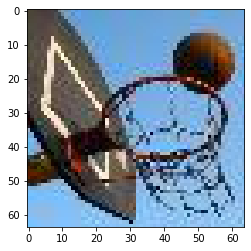

In [22]:
plt.imshow(img)

In [23]:
img.shape

(64, 64, 3)